In [ ]:
## Integrate all BES age data!

In [49]:
dataset_name = "W14_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
           "BESnon_numeric"
          ]


import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re, Jupyter_module_loader, gaussian_kde

from IPython.display import display, display_html, HTML
from utility import *

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)




var_type (5692, 13)


In [ ]:
## Goal
# - get an age estimate for *all* BES respondents
# - get equal size ageGroups
# - identify which wave variables are sampled in, which dates ages refer to

In [5]:
BES_reduced_with_na[ search(BES_reduced_with_na,"ageGroup|^age") ]

ageW1            30386
ageW7            30895
ageW8            33502
ageW9            30036
ageW11           30956
ageW12           34394
ageW13           31136
ageW14           31063
age              18059
ageGroup__66+    18108
Age              39142
dtype: int64

In [27]:
BES_reduced_with_na[ search(BES_reduced_with_na,"ageGroup|^age").index ].describe()

,ageW1,ageW7,ageW8,ageW9,ageW11,ageW12,ageW13,ageW14,age,ageGroup__66+,Age
count,30386.000000,30895.000000,33502.000000,30036.000000,30956.000000,34394.000000,31136.000000,31063.000000,18059.000000,18108.000000,39142.000000
mean,51.386692,50.750252,52.393200,53.114128,51.843521,52.401638,52.550137,52.314491,40.795948,3.356141,48.473507
std,15.897443,16.598715,16.167723,15.783805,16.218578,16.214859,15.932261,16.356621,16.681498,1.769118,16.705090
min,4.000000,18.000000,18.000000,18.000000,18.000000,18.000000,7.000000,18.000000,16.000000,0.000000,15.000000
25%,39.000000,37.000000,39.000000,41.000000,39.000000,40.000000,40.000000,39.000000,24.000000,2.000000,35.000000
50%,54.000000,53.000000,55.000000,56.000000,54.000000,55.000000,55.000000,54.000000,40.000000,3.000000,51.000000
75%,64.000000,64.000000,66.000000,66.000000,65.000000,66.000000,66.000000,66.000000,54.000000,5.000000,62.000000
max,105.000000,97.000000,96.000000,116.000000,92.000000,97.000000,93.000000,101.000000,116.000000,6.000000,95.000000


In [9]:
amalgamated_age = amalgamate_waves(BES_reduced_with_na,'^ageW\d+')

Amalgamating variables: 
{1: 'ageW1', 7: 'ageW7', 8: 'ageW8', 9: 'ageW9', 11: 'ageW11', 12: 'ageW12', 13: 'ageW13', 14: 'ageW14'}


In [10]:
amalgamated_age.notnull().sum()

67223

In [16]:
(amalgamated_age.notnull() | BES_reduced_with_na["age"].notnull() | BES_reduced_with_na["Age"].notnull() ).sum()

72356

In [13]:
BES_reduced_with_na.shape

(73703, 6864)

In [18]:
(BES_reduced_with_na["age"] - BES_reduced_with_na["Age"]).value_counts()

 0.0    3065
 1.0     615
-1.0     197
-2.0       1
 2.0       1
dtype: int64

In [75]:
(BES_reduced_with_na["ageW14"] - BES_reduced_with_na["ageW1"]).value_counts().sort_index()

-36.0       1
-25.0       1
-22.0       1
-16.0       1
-12.0       1
-9.0        1
-6.0        6
-5.0        2
-3.0        1
-2.0        3
-1.0        3
 0.0        1
 1.0        2
 2.0       34
 3.0      136
 4.0     9180
 5.0     1838
 6.0        6
 7.0        2
 8.0        1
 9.0        5
 10.0       1
 11.0       4
 12.0       1
 14.0       3
 15.0       2
 17.0       1
 30.0       1
 33.0       1
 34.0       1
 44.0       1
 49.0       1
dtype: int64

In [93]:
(BES_reduced_with_na["age"] - BES_reduced_with_na["Age"]).mean()

0.10775972902774811

In [79]:
set(BES_file_manifest["Date_Start"])
# Feb-14 - May-18

{'Apr-16',
 'Apr-17',
 'Feb-14',
 'Jun-16',
 'Jun-17',
 'Mar-15',
 'May-14',
 'May-15',
 'May-16',
 'May-17',
 'May-18',
 'Nov-16',
 'Sep-14'}

In [ ]:
# some really significantly different answers in age!
# ageW1 is worst

In [59]:
BESnon_numeric[[x for x in BESnon_numeric if "wave" in x]].corrwith(BES_reduced_with_na["ageW14"].notnull().astype('float'))

wave1    -0.085039
wave2    -0.050019
wave3     0.002376
wave4     0.019756
wave5     0.024498
wave6     0.044077
wave7     0.154192
wave8     0.197012
wave9     0.243133
wave10    0.286639
wave11    0.357978
wave12    0.343967
wave13    0.404430
wave14    1.000000
dtype: float64

In [74]:
BESnon_numeric[[x for x in BESnon_numeric if "wave" in x]].corrwith(BES_Panel["ageW1"].notnull().astype('float'))

wave1     0.995806
wave2     0.808506
wave3     0.619113
wave4     0.502046
wave5     0.526670
wave6     0.526887
wave7     0.246892
wave8     0.128200
wave9     0.144268
wave10   -0.025161
wave11   -0.001197
wave12    0.004650
wave13    0.013636
wave14   -0.087277
dtype: float64

In [ ]:
# ageGroup 37% of wave8, Age 80% of wave7, age 14% of wave10 (looks like top up?)
# all ageWX get 100% on their wave, except for ageW1 with 99.5%

# age, Age, ageW1 all seem pegged at wave1 sampling

# ageW1 most problematic

In [ ]:

ageW1	ageW7	ageW8	ageW9	ageW11	ageW12	ageW13	ageW14	age	Age	ageGroup__66+
739	43.0	NaN	NaN	NaN	NaN	NaN	NaN	54.0	NaN	NaN	NaN
2944	55.0	NaN	36.0	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN

In [94]:
# just ageWX variables

ageW_vars = BES_reduced_with_na[ search(BES_reduced_with_na,"^ageW\d+").index ]
ageW_vars.notnull().sum(axis=1).value_counts().sort_index()

0     6480
1    19136
2     7227
3     8011
4     7909
5     5189
6     6748
7     7348
8     5655
dtype: int64

In [212]:
# just ageWX variables

ageW_vars = BES_reduced_with_na[ search(BES_reduced_with_na,"^ageW\d+|^age$|^Age$").index ].copy()
ageW_vars[ageW_vars<15] = np.nan
ageW_vars[ageW_vars>105] = np.nan
ageW_vars.loc[33553,"ageW8"] = np.nan
ageW_vars.loc[739,"ageW1"] = np.nan
ageW_vars.loc[2944,"ageW1"] = np.nan
ageW_vars.notnull().sum(axis=1).value_counts().sort_index()

0        2
1    21624
2     5728
3     6598
4     7067
5     7835
6     4962
7     6383
8     6744
9     6760
dtype: int64

In [213]:
age_var_num = ageW_vars.notnull().sum(axis=1)
obvious_disparities = (ageW_vars.max(axis=1)-ageW_vars.min(axis=1))>=7
obvious_disparities.sum()

age_var_num[obvious_disparities].value_counts().sort_index()
# not much to be done about those 7!

2     4
3     7
4     6
5    14
6     1
7    13
8    20
9    20
dtype: int64

In [214]:
easy_filterable = ((obvious_disparities) &  (age_var_num>=3))
len( easy_filterable[easy_filterable].index )

81

In [215]:
dict_of_bad_variables = {}
for ind in easy_filterable[easy_filterable].index:
#     first = easy_filterable[easy_filterable].index[0]
    mean_age = ageW_vars.loc[ind].mean()
    age_abs_dev = np.abs(ageW_vars.loc[ind] - mean_age)

    bad_variable = age_abs_dev.dropna().sort_values(ascending=False).index[0]
    bad_deviation = age_abs_dev.dropna().sort_values(ascending=False).values[0]
    dict_of_bad_variables[ind] = (bad_variable,bad_deviation)
    
    ageW_vars.loc[ind,bad_variable] = np.nan

In [216]:
dict_of_bad_variables

{1434: ('ageW1', 8.875),
 1492: ('ageW1', 6.7777786),
 1623: ('ageW1', 13.375),
 1743: ('ageW1', 23.666668),
 2191: ('ageW1', 4.25),
 2681: ('ageW14', 11.666668),
 2709: ('ageW1', 6.25),
 2891: ('ageW1', 5.4000015),
 3576: ('ageW1', 12.125),
 3687: ('ageW1', 15.599998),
 5167: ('ageW1', 6.7777786),
 5634: ('ageW1', 13.400002),
 6611: ('ageW1', 4.875),
 6682: ('ageW1', 12.666668),
 6819: ('ageW1', 13.285713),
 7236: ('ageW1', 5.625),
 7370: ('ageW14', 4.8888893),
 7394: ('ageW1', 24.875),
 7848: ('ageW1', 11.42857),
 7980: ('ageW1', 4.1428566),
 10060: ('ageW1', 27.88889),
 10510: ('ageW1', 5.666668),
 10522: ('ageW1', 23.285713),
 10566: ('ageW1', 5.375),
 10748: ('ageW1', 8.333332),
 11024: ('ageW1', 6.875),
 12356: ('ageW1', 7.1428604),
 12569: ('ageW1', 5.875),
 12728: ('ageW1', 8.125),
 13192: ('ageW1', 6.333332),
 13498: ('ageW1', 6.7777786),
 14034: ('ageW1', 32.14286),
 14107: ('ageW1', 10.0),
 14112: ('ageW1', 8.25),
 14419: ('ageW1', 8.0),
 14492: ('ageW1', 11.0),
 15111: ('ag

In [288]:
from scipy.optimize import curve_fit

def match_age(x, ageW7c, ageW8c, ageW9c,ageW11c,ageW12c,ageW13c,ageW14c,agec,Agec):
    x = pd.DataFrame(x, columns = ['ageW1', 'ageW7', 'ageW8', 'ageW9', 'ageW11', 'ageW12', 'ageW13',
       'ageW14', 'age', 'Age']).replace(0, np.nan)
    x["ageW7"]  -= ageW7c
    x["ageW8"]  -= ageW8c
    x["ageW9"]  -= ageW9c    
    x["ageW11"] -= ageW11c
    x["ageW12"] -= ageW12c
    x["ageW13"] -= ageW13c
    x["ageW14"] -= ageW14c
    x["age"] -= 2   
    x["Age"] -= 0
    return x.std(axis=1)
    
    

In [289]:
ydata.shape

(52077,)

In [290]:
comparisons_possible = ageW_vars.notnull().sum(axis=1)>=2
ydata = np.zeros(sum(comparisons_possible))



popt, pcov = curve_fit(match_age, ageW_vars[comparisons_possible].replace(np.nan,0).values, ydata, p0=[2,2,2, 3,3,3, 4,2,0])

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [291]:
popt

array([2.13014203, 2.2389054 , 2.31467474, 2.97749091, 3.10231741,
       3.18945768, 4.09744989, 2.        , 0.        ])

In [305]:
ageW_vars_matched = ageW_vars.copy()
ageW_vars_matched["ageW7"]  -= popt[0]
ageW_vars_matched["ageW8"]  -= popt[1]
ageW_vars_matched["ageW9"]  -= popt[2]    
ageW_vars_matched["ageW11"] -= popt[3]
ageW_vars_matched["ageW12"] -= popt[4]
ageW_vars_matched["ageW13"] -= popt[5]
ageW_vars_matched["ageW14"] -= popt[6]
ageW_vars_matched["age"] -= 2    
ageW_vars_matched["Age"] -= 0

In [ ]:
# dict_of_bad_variables = {}
# for ind in easy_filterable[easy_filterable].index:
# #     first = easy_filterable[easy_filterable].index[0]
#     mean_age = ageW_vars.loc[ind].mean()
#     age_abs_dev = np.abs(ageW_vars.loc[ind] - mean_age)

#     bad_variable = age_abs_dev.dropna().sort_values(ascending=False).index[0]
#     bad_deviation = age_abs_dev.dropna().sort_values(ascending=False).values[0]
#     dict_of_bad_variables[ind] = (bad_variable,bad_deviation)
    
#     ageW_vars.loc[ind,bad_variable] = np.nan

In [2]:
# ageW_vars_matched.loc[0]

In [324]:
# max_minus_min = ageW_vars_matched.max(axis=1) - ageW_vars_matched.min(axis=1)
# max_minus_min[max_minus_min>4].value_counts().sum()

age_var_num = ageW_vars_matched.notnull().sum(axis=1)
obvious_disparities = (ageW_vars_matched.max(axis=1)-ageW_vars_matched.min(axis=1))>=4
obvious_disparities.sum()

age_var_num[obvious_disparities].value_counts().sort_index()
# not much to be done about those 7!


2    6
3    3
4    6
5    2
6    1
8    4
9    5
dtype: int64

In [325]:
easy_filterable = ((obvious_disparities) &  (age_var_num>=3))
len( easy_filterable[easy_filterable].index )

21

In [328]:
dict_of_bad_variables = {}
for ind in easy_filterable[easy_filterable].index:
#     first = easy_filterable[easy_filterable].index[0]
    mean_age = ageW_vars_matched.loc[ind].mean()
    age_abs_dev = np.abs(ageW_vars_matched.loc[ind] - mean_age)

    bad_variable = age_abs_dev.dropna().sort_values(ascending=False).index[0]
    bad_deviation = age_abs_dev.dropna().sort_values(ascending=False).values[0]
    dict_of_bad_variables[ind] = (bad_variable,bad_deviation)
    
    ageW_vars.loc[ind,bad_variable] = np.nan
    ageW_vars_matched.loc[ind,bad_variable] = np.nan

In [329]:
dict_of_bad_variables

{4816: ('ageW1', 3.8944931176985875),
 5105: ('ageW1', 3.7943145532258313),
 6819: ('ageW14', 8.389266112787269),
 7081: ('ageW1', 4.493515081673451),
 8979: ('ageW1', 4.361204191412796),
 9278: ('ageW1', 5.116715339920816),
 11577: ('ageW14', 3.5362901085041116),
 13083: ('ageW1', 3.3691235208022476),
 15352: ('ageW1', 5.450048673254152),
 20962: ('ageW1', 4.101634280153355),
 23175: ('ageW1', 4.509118393144131),
 24699: ('ageW1', 4.043380675115831),
 25911: ('ageW1', 4.494123520802248),
 30517: ('Age', 3.3746359692768024),
 38389: ('age', 6.067316500597762),
 41807: ('age', 3.438840215634741),
 47885: ('ageW7', 24.030290018412853),
 51870: ('ageW9', 3.4634813607439057),
 62156: ('ageW11', 15.6358119403192),
 63967: ('ageW13', 3.3778588182406573),
 65559: ('ageW14', 2.9275303761318554)}

In [334]:
cleaned_ages = ageW_vars_matched.mean(axis=1)
cleaned_ages.to_msgpack(BES_small_data_files+"cleaned_ages")

In [335]:
pred_ages = pd.read_msgpack(BES_small_data_files+"pred_ages" )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000004744B470>]],
      dtype=object)

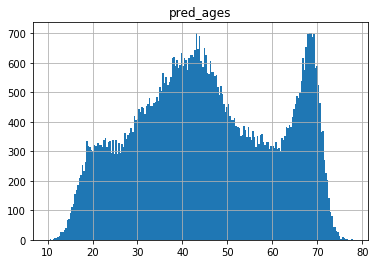

In [336]:
pred_ages.hist(bins=200)

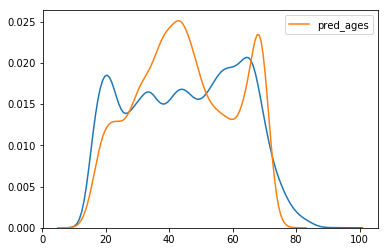

In [347]:
sns.kdeplot(cleaned_ages);
sns.kdeplot(pred_ages["pred_ages"]);

## doesn't look amazing ... but pseudo-R^2 ~80%

In [381]:
## lets see if this helps disambiguate ages with two discrepant values

paired_weird_ages = ((obvious_disparities) &  (age_var_num==2))
pd.concat( [ ageW_vars_matched.loc[paired_weird_ages],
             BES_reduced_with_na.loc[ageW_vars_matched.loc[paired_weird_ages].index,"ageGroup__66+"].apply(lambda x: cat_dictionary["ageGroup"][int(x)] if not np.isnan(x) else x) ,
             pred_ages.loc[paired_weird_ages] ],          
             axis=1)

# meh -ish
# 63078 drop ageW13 -> profile_education_age says they've left education *after* 19, edlevel postgrad
# 63211 drop age -> fully owns house, more likely 50 than 20


In [382]:
# BES_Panel.loc[67676,top_age_correlates_bespanel].dropna()

ageW_vars.loc[63078,"ageW13"] = np.nan
ageW_vars_matched.loc[63078,"ageW13"] = np.nan

ageW_vars.loc[63211,"age"] = np.nan
ageW_vars_matched.loc[63211,"age"] = np.nan

In [386]:
age_var_num

0        5
1        9
2        7
3        1
4        1
5        5
6        8
7        7
8        9
9        5
10       4
11       1
12       1
13       4
14       8
15       1
16       5
17       7
18       5
19       1
20       1
21       2
22       5
23       4
24       1
25       3
26       3
27       1
28       9
29       9
        ..
73673    1
73674    1
73675    1
73676    1
73677    1
73678    1
73679    1
73680    1
73681    1
73682    1
73683    1
73684    1
73685    1
73686    1
73687    1
73688    1
73689    1
73690    1
73691    1
73692    1
73693    1
73694    1
73695    1
73696    1
73697    1
73698    1
73699    1
73700    1
73701    1
73702    1
Length: 73703, dtype: int64

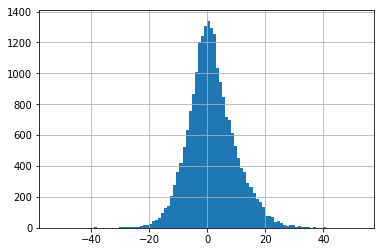

In [393]:
# disparities between single age variable and pred_ages
# not great, but at least reasonably normal looking
(ageW_vars.loc[(age_var_num==1)].sum(axis=1)-pred_ages.loc[(age_var_num==1)]["pred_ages"]).hist(bins=100)

In [396]:
# respondents that post cleaning have *no* age variables?
# substitute in pred_ages (better than obvious gibberish/nothing!)
ageW_vars.loc[(age_var_num==0)]
pred_ages.loc[(age_var_num==0)]
ageW_vars_matched.loc[12229,"Age"] = 41.688381
ageW_vars_matched.loc[62207,"Age"] = 27.849688

In [ ]:
####################################################
# enough trimming

# take mean of current 'time-matched' age variables

# get W1-based float Age for all respondents and rounded version
# get float version for Age_at_each_wave
# get W1-based standard ageGroup
# get equal bin sized version of ageGroup









# TODO: proper handling of age-rounding (if someone is "32", they are really somewhere between 32 and 33)
# TODO: extra age discrepancy checks - e.g. profile_education_age should not be larger than your age! Ditto, retirement
# TODO: helper functions to get age for *any* wave/rounded/as either type of ageGroup


In [405]:

BES_Panel["ageGroup"].cat.categories


Index(['Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', '66+'], dtype='object')

In [467]:
# pd.cut(Age_at_W1, bins = [ 18, 25,35,45,55,65])
standard_age_groups = pd.IntervalIndex.from_arrays([0, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
standardAgeGroup_at_W1 = pd.cut(Age_at_W1_rounded, standard_age_groups, labels = BES_Panel["ageGroup"].cat.categories)
standardAgeGroup_at_W1.cat.rename_categories(BES_Panel["ageGroup"].cat.categories, inplace=True)
standardAgeGroup_at_W1.value_counts().sort_index()

Under 18     2968
18-25       10200
26-35       11399
36-45       11593
46-55       11939
56-65       14656
66+         10948
dtype: int64

In [496]:
# equal_length_age_groups = pd.IntervalIndex.from_arrays([13, 18, 26,36,46,56,66], [17, 25, 35, 45, 55, 65, 120], closed = 'both')
equalLengthAgeGroup_at_W1 = pd.cut(Age_at_W1_rounded, range(10,96,5) )
# standardAgeGroup_at_W1.cat.rename_categories(BES_Panel["ageGroup"].cat.categories, inplace=True)
equalLengthAgeGroup_at_W1.value_counts().sort_index()

(10, 15]     716
(15, 20]    6401
(20, 25]    6051
(25, 30]    5220
(30, 35]    6179
(35, 40]    5346
(40, 45]    6247
(45, 50]    5749
(50, 55]    6190
(55, 60]    7183
(60, 65]    7473
(65, 70]    6573
(70, 75]    2860
(75, 80]    1105
(80, 85]     378
(85, 90]      26
(90, 95]       6
dtype: int64

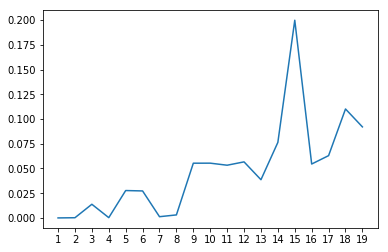

In [466]:
frac_diff_between_emptiest_fullest_bin = []
q_values = range(1,20)
for q in q_values:
    x = pd.qcut(Age_at_W1,q=q, precision=0).value_counts().sort_index()
    (x/x.mean()).max(),(x/x.mean()).min()
    frac_diff_between_emptiest_fullest_bin.append( (x/x.mean()).max() - (x/x.mean()).min() )

plt.plot(q_values,frac_diff_between_emptiest_fullest_bin);
plt.xticks(q_values);
# frac_diff_between_emptiest_fullest_bin

# 8 split is best balance between number of categories and flatness of categories


In [470]:
equalisedAgeGroup_at_W1 = pd.qcut(Age_at_W1,q=8, precision=0)
equalisedAgeGroup_at_W1.value_counts().sort_index()


(13.0, 22.0]    9213
(22.0, 31.0]    9213
(31.0, 38.0]    9221
(38.0, 46.0]    9208
(46.0, 54.0]    9226
(54.0, 60.0]    9198
(60.0, 67.0]    9212
(67.0, 95.0]    9212
dtype: int64

In [5]:
# Age_at_W1 = ageW_vars_matched.mean(axis=1)
# Age_at_W1_rounded = Age_at_W1.round()

In [498]:
Age_at_W1 = ageW_vars_matched.mean(axis=1)
Age_at_W1_rounded = Age_at_W1.round()
Age_at_W7 = Age_at_W1 + popt[0]
Age_at_W8 = Age_at_W1 + popt[1]
Age_at_W9 = Age_at_W1 + popt[2]
Age_at_W11 = Age_at_W1 + popt[3]
Age_at_W12 = Age_at_W1 + popt[4]
Age_at_W13 = Age_at_W1 + popt[5]
Age_at_W14 = Age_at_W1 + popt[6]

standardAgeGroup_at_W1
equalisedAgeGroup_at_W1

pan_dataset_ages = pd.concat([BES_Panel["id"].astype('int'),
                              Age_at_W1,
                              Age_at_W1_rounded,
                              Age_at_W7,
                              Age_at_W8,
                              Age_at_W9,
                              Age_at_W11,
                              Age_at_W12,
                              Age_at_W13,
                              Age_at_W14,
                              standardAgeGroup_at_W1,
                              equalisedAgeGroup_at_W1,
                              equalLengthAgeGroup_at_W1]
                              ,axis=1)

pan_dataset_ages.columns = ["id",
                            "Age_at_W1","Age_at_W1_rounded","Age_at_W7","Age_at_W8","Age_at_W9",
                            "Age_at_W11","Age_at_W12","Age_at_W13","Age_at_W14",
                            "standardAgeGroup_at_W1","equalisedAgeGroup_at_W1","equalLengthAgeGroup_at_W1"]
pan_dataset_ages["Age_at_W1_rounded"] = pan_dataset_ages["Age_at_W1_rounded"].astype('int8')

# pan_dataset_ages["id"] = BES_Panel["id"].astype('int')

pan_dataset_ages.to_csv(    BES_small_data_files + "pan_dataset_ages"+".csv", index=False)
pan_dataset_ages.to_msgpack(BES_small_data_files + "pan_dataset_ages"+".msgpack")

In [499]:
pan_dataset_ages

,id,Age_at_W1,Age_at_W1_rounded,Age_at_W7,Age_at_W8,Age_at_W9,Age_at_W11,Age_at_W12,Age_at_W13,Age_at_W14,standardAgeGroup_at_W1,equalisedAgeGroup_at_W1,equalLengthAgeGroup_at_W1
0,1,57.863256,58,59.993398,60.102161,60.177930,60.840746,60.965573,61.052713,61.960705,56-65,"(54.0, 60.0]","(55, 60]"
1,2,61.883285,62,64.013427,64.122190,64.197959,64.860776,64.985602,65.072742,65.980735,56-65,"(60.0, 67.0]","(60, 65]"
2,3,75.929020,76,78.059162,78.167926,78.243695,78.906511,79.031338,79.118478,80.026470,66+,"(67.0, 95.0]","(75, 80]"
3,4,51.000000,51,53.130142,53.238905,53.314675,53.977491,54.102317,54.189458,55.097450,46-55,"(46.0, 54.0]","(50, 55]"
4,5,68.000000,68,70.130142,70.238905,70.314675,70.977491,71.102317,71.189458,72.097450,66+,"(67.0, 95.0]","(65, 70]"
5,6,48.940582,49,51.070724,51.179487,51.255257,51.918073,52.042899,52.130040,53.038032,46-55,"(46.0, 54.0]","(45, 50]"
6,7,56.908030,57,59.038172,59.146935,59.222704,59.885520,60.010347,60.097487,61.005479,56-65,"(54.0, 60.0]","(55, 60]"
7,8,65.929020,66,68.059162,68.167926,68.243695,68.906511,69.031338,69.118478,70.026470,66+,"(60.0, 67.0]","(65, 70]"
8,9,50.883285,51,53.013427,53.122190,53.197959,53.860776,53.985602,54.072742,54.980735,46-55,"(46.0, 54.0]","(50, 55]"
9,10,82.890573,83,85.020715,85.129479,85.205248,85.868064,85.992891,86.080031,86.988023,66+,"(67.0, 95.0]","(80, 85]"


In [489]:
# pan_dataset_ages = pd.read_csv(    BES_small_data_files + "pan_dataset_ages"+".csv")

In [490]:
# pan_dataset_ages

,id,Age_at_W1,Age_at_W1_rounded,Age_at_W7,Age_at_W8,Age_at_W9,Age_at_W11,Age_at_W12,Age_at_W13,Age_at_W14,standardAgeGroup_at_W1,equalisedAgeGroup_at_W1
0,1,57.863256,58,59.993398,60.102161,60.177930,60.840746,60.965573,61.052713,61.960705,56-65,"(54.0, 60.0]"
1,2,61.883285,62,64.013427,64.122190,64.197959,64.860776,64.985602,65.072742,65.980735,56-65,"(60.0, 67.0]"
2,3,75.929020,76,78.059162,78.167926,78.243695,78.906511,79.031338,79.118478,80.026470,66+,"(67.0, 95.0]"
3,4,51.000000,51,53.130142,53.238905,53.314675,53.977491,54.102317,54.189458,55.097450,46-55,"(46.0, 54.0]"
4,5,68.000000,68,70.130142,70.238905,70.314675,70.977491,71.102317,71.189458,72.097450,66+,"(67.0, 95.0]"
5,6,48.940582,49,51.070724,51.179487,51.255257,51.918073,52.042899,52.130040,53.038032,46-55,"(46.0, 54.0]"
6,7,56.908030,57,59.038172,59.146935,59.222704,59.885520,60.010347,60.097487,61.005479,56-65,"(54.0, 60.0]"
7,8,65.929020,66,68.059162,68.167926,68.243695,68.906511,69.031338,69.118478,70.026470,66+,"(60.0, 67.0]"
8,9,50.883285,51,53.013427,53.122190,53.197959,53.860776,53.985602,54.072742,54.980735,46-55,"(46.0, 54.0]"
9,10,82.890573,83,85.020715,85.129479,85.205248,85.868064,85.992891,86.080031,86.988023,66+,"(67.0, 95.0]"


In [188]:
ageW_vars.min()

ageW1     15.0
ageW7     18.0
ageW8     18.0
ageW9     18.0
ageW11    18.0
ageW12    18.0
ageW13    16.0
ageW14    18.0
age       16.0
Age       15.0
dtype: float32

In [101]:
(ageW_vars.max(axis=1)-ageW_vars.min(axis=1)).value_counts()

0.0     24771
4.0     20012
3.0     11776
2.0      8403
1.0      4665
5.0      3915
6.0        72
9.0        12
8.0        10
7.0         8
10.0        8
11.0        7
16.0        4
30.0        4
12.0        3
13.0        3
14.0        3
19.0        2
29.0        2
15.0        2
28.0        2
36.0        2
17.0        2
21.0        1
82.0        1
18.0        1
54.0        1
33.0        1
50.0        1
22.0        1
40.0        1
34.0        1
26.0        1
35.0        1
49.0        1
31.0        1
44.0        1
46.0        1
dtype: int64

In [ ]:
# Are any waves more likely to be problematic?



In [107]:
for ind in obvious_disparities[obvious_disparities].index:
    

Int64Index([  739,  1434,  1492,  1623,  1743,  2191,  2681,  2709,  2891,
             2944,  3576,  3687,  5167,  5634,  6611,  6682,  6819,  7236,
             7370,  7394,  7848,  7980, 10060, 10510, 10522, 10566, 10748,
            11024, 12356, 12569, 12728, 13192, 13498, 14034, 14107, 14112,
            14419, 14492, 15111, 16009, 16309, 17711, 17737, 17993, 18939,
            18947, 19463, 19795, 20035, 20525, 20648, 21467, 21541, 21797,
            22348, 22762, 23665, 23805, 24149, 25035, 25274, 25713, 30724,
            31037, 33553, 33605, 33842, 38389, 47338, 47885, 48998, 49716,
            50994, 53343, 56498, 59197, 62156, 62564, 62913, 63078, 63211,
            63258, 63286, 63882, 66113, 66382, 67296, 67676, 67729],
           dtype='int64')

In [108]:
BESnon_numeric[[x for x in BESnon_numeric if "wave" in x]].corrwith(obvious_disparities)

wave1     0.020245
wave2     0.022622
wave3    -0.018226
wave4     0.002505
wave5     0.002296
wave6     0.012469
wave7     0.015592
wave8     0.016120
wave9     0.018867
wave10    0.017861
wave11    0.021862
wave12    0.020727
wave13    0.024837
wave14    0.013047
dtype: float64

In [109]:
age_corrs = BES_reduced_with_na.corrwith(BES_reduced_with_na["Age"])
age_corrs.dropna().sort_values()

studentloanW14_Yes                                                         -0.560034
mainSourceIncomeW11_Earnings from employment (own or spouse / partner's)   -0.533738
marital_Never married                                                      -0.507547
workingStatusW14_Working full time (30 or more hours per week)             -0.489858
profile_work_statW14_Working full time (30 or more hours per week)         -0.487237
mainSourceIncomeW6_Earnings from employment (own or spouse / partner's)    -0.485527
allSourceIncome_1W11_Yes                                                   -0.482802
profile_work_statW12_Working full time (30 or more hours per week)         -0.460642
profile_work_statW13_Working full time (30 or more hours per week)         -0.456699
profile_education_age__Still at school/Full time student                   -0.444609
profile_work_statW11_Working full time (30 or more hours per week)         -0.444034
allSourceIncome_1W6_Yes                                          

In [375]:
top_age_correlates = age_corrs.abs()[age_corrs.abs()>age_corrs.abs().quantile(.95)].sort_values(ascending=False).index

In [376]:
top_age_correlates_bespanel = list(set([new_old_col_names[x] for x in top_age_correlates if x in new_old_col_names.keys()]))

In [118]:
easy_filterable = ((obvious_disparities) &  (age_var_num>=3))
len( easy_filterable[easy_filterable].index )
# 7 obvious disparities

82

In [210]:
paired_weird_ages = ((obvious_disparities) &  (age_var_num==2))
pd.concat( [ ageW_vars.loc[paired_weird_ages],
             BES_reduced_with_na.loc[ageW_vars.loc[paired_weird_ages].index,"ageGroup__66+"].apply(lambda x: cat_dictionary["ageGroup"][int(x)] if not np.isnan(x) else x) ],
            axis=1)
# BES_reduced_with_na.loc[ageW_vars.loc[paired_weird_ages].index,"ageGroup__66+"]

,ageW1,ageW7,ageW8,ageW9,ageW11,ageW12,ageW13,ageW14,age,Age,ageGroup__66+
62564,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,19.0,NaN,NaN
63078,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,29.0,NaN,NaN
63211,NaN,NaN,NaN,NaN,52.0,NaN,NaN,NaN,22.0,NaN,NaN
67676,NaN,NaN,NaN,NaN,NaN,30.0,38.0,NaN,NaN,NaN,NaN


26.0

In [143]:
BES_Panel["ageGroup"].cat.categories

Index(['Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', '66+'], dtype='object')

In [123]:
ageW_vars.max()
# oldest person in UK is 112!
# https://en.wikipedia.org/wiki/List_of_British_supercentenarians

ageW1     105.0
ageW7      97.0
ageW8      96.0
ageW9     116.0
ageW11     92.0
ageW12     97.0
ageW13     93.0
ageW14    101.0
age       116.0
Age        95.0
dtype: float32

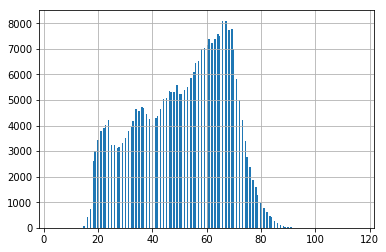

In [126]:
ageW_vars.stack().hist(bins=200);

In [178]:
ageW_vars[ageW_vars<15].stack().value_counts()

Series([], dtype: int64)

In [179]:
ageW_vars[ageW_vars>100].stack().value_counts()

101.0    1
105.0    1
dtype: int64

In [167]:
only_one_age_var = ageW_vars.loc[age_var_num==1]
only_one_age_var[only_one_age_var>100][ only_one_age_var[only_one_age_var>100].any(axis=1) ]

,ageW1,ageW7,ageW8,ageW9,ageW11,ageW12,ageW13,ageW14,age,Age
62207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.0,NaN


In [ ]:
## people claiming to be 4(1), 7(1), 116(2) -> should probably be dismissed! - 4/7 both same respondend!
# one of the 116's is in a row with no other variable!!! 62207

# 33553	ageW8 26.0	Age 15.0	Under 18 -> so, assumed ageW8 is wrong?

In [184]:
age_var_num[age_var_num==0].index

Int64Index([12229, 62207], dtype='int64')

In [185]:
BES_reduced_with_na[ search(BES_reduced_with_na,"^ageW\d+|^age$|^Age$").index ].loc[[12229, 62207]]

,ageW1,ageW7,ageW8,ageW9,ageW11,ageW12,ageW13,ageW14,age,Age
12229,4.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN
62207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.0,NaN
